In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/ 255)
test_datagen = ImageDataGenerator(rescale = 1/ 255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [4]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, trainable = False, input_shape = (224, 224, 3))
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation = "softmax", name = "OUTPUT_LAYER")
    ])
  
  return model

In [13]:
resnet_model = create_model("https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2", 10)

In [15]:
resnet_model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 OUTPUT_LAYER (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20241106-184556
Epoch 1/5
24/24 [==============================] - 41s 2s/step - loss: 1.9199 - accuracy: 0.3800 - val_loss: 1.2958 - val_accuracy: 0.5536
Epoch 2/5
24/24 [==============================] - 11s 471ms/step - loss: 0.9196 - accuracy: 0.7200 - val_loss: 0.8754 - val_accuracy: 0.7272
Epoch 3/5
24/24 [==============================] - 13s 535ms/step - loss: 0.6319 - accuracy: 0.8160 - val_loss: 0.7639 - val_accuracy: 0.7616
Epoch 4/5
24/24 [==============================] - 11s 449ms/step - loss: 0.4896 - accuracy: 0.8760 - val_loss: 0.7169 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 8s 337ms/step - loss: 0.3801 - accuracy: 0.9213 - val_loss: 0.6857 - val_accuracy: 0.7768


In [17]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

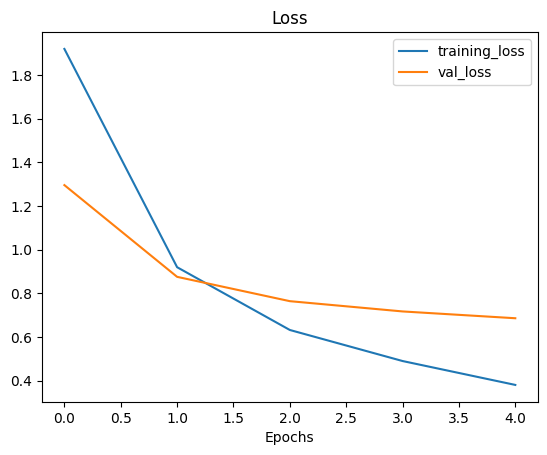

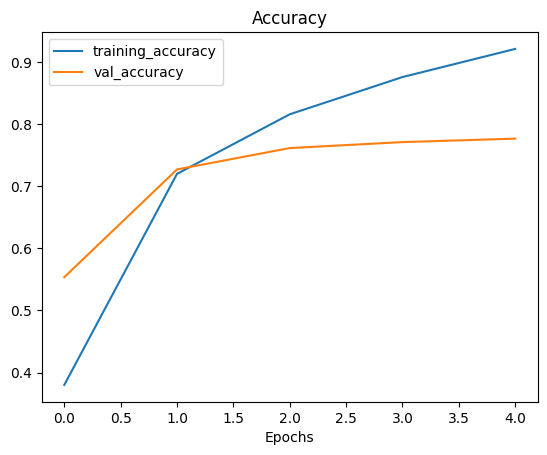

In [18]:
plot_loss_curves(resnet_history)

In [19]:
efficient_net_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"

In [20]:
efficientnet_model = create_model(efficient_net_url, 10)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data, 
                                              epochs=5, # train for 5 epochs
                                              validation_data=test_data,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20241106-202302
Epoch 1/5
24/24 [==============================] - 22s 581ms/step - loss: 1.9743 - accuracy: 0.3507 - val_loss: 1.5094 - val_accuracy: 0.6144
Epoch 2/5
24/24 [==============================] - 10s 433ms/step - loss: 1.3133 - accuracy: 0.6853 - val_loss: 1.1213 - val_accuracy: 0.7152
Epoch 3/5
24/24 [==============================] - 9s 400ms/step - loss: 1.0162 - accuracy: 0.7653 - val_loss: 0.9483 - val_accuracy: 0.7440
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.8524 - accuracy: 0.7880 - val_loss: 0.8558 - val_accuracy: 0.7600
Epoch 5/5
24/24 [==============================] - 12s 533ms/step - loss: 0.7445 - accuracy: 0.8227 - val_loss: 0.8020 - val_accuracy: 0.7696


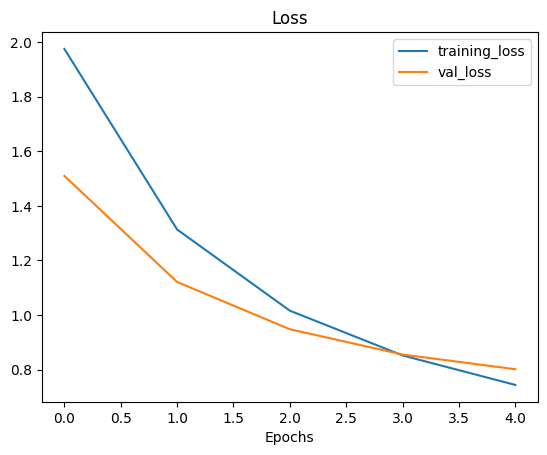

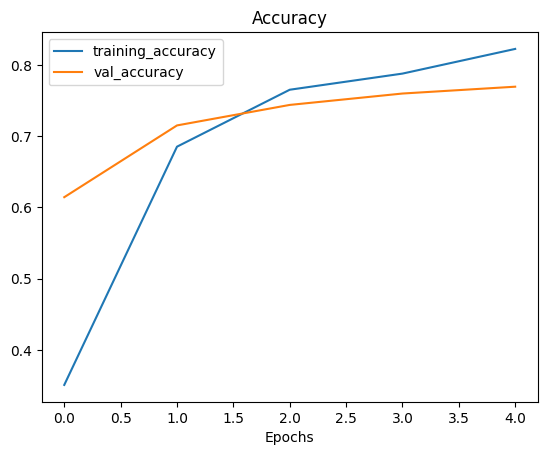

In [21]:
plot_loss_curves(efficientnet_history)

In [22]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 OUTPUT_LAYER (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 OUTPUT_LAYER (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________
